We proceed with the 1D cornea problem in this new notebook so as to make compilation faster and more concise. We will fix the issue presented at the end of the first notebook.

We've changed the fitting polynomial order, changed the evolution fucntion so as to provide the previous frame's equilibrium dislacements as a an initial guess for the iterative algorithm that find the displacements on a give frame, and we will now assess strong fluctuations between consecutive frames to find the root of the main issue affecting the smoothness of our predicted $U(t)$ curve.

We import all necessary functions and modules below.

In [1]:
## loading python libraries

# necessary to display plots inline:
%matplotlib inline

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing

from scipy.optimize import fsolve   # Numerically solve non-linear system of equations
from scipy.optimize import minimize # Numerically minimize scalar multivariable function

from math import *              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cv2                      # In case I have to write code similar to that of Wu Yifan
import os
import matplotlib.animation as ani
import sympy as sp
import utils                    # Wu Yifan's image/video processing functions
from PIL import Image           # Movie creation
import threading                # MultiThreading
import random

In [2]:
utils.initialize()  #Initialize directories (if they don't exist)

In [3]:
N = 100
K = np.ones(N+1)  # Subject to change after careful analysis - Vector for N+1 segments

In [4]:
def initialLengthsFinder(x_0, y_0):  #Returns the N+1 segment Lengths, take N+2
                                     #node coordinates
    lengths = np.zeros(N+1)
    for i in range(x_0.shape[0]-1):
        length = sqrt((x_0[i]-x_0[i+1])**2 +(y_0[i]-y_0[i+1])**2)
        lengths[i] = length
    return lengths

In [5]:
def euclideanDistance(xy_1, xy_2): #probably existing function
    return sqrt(((xy_1[0]-xy_2[0])**2)+((xy_1[1]-xy_2[1])**2))

In [6]:
def slope(xy1, xy2):
    return (xy2[1] - xy1[1]) / (xy2[0] - xy1[0])

In [7]:
def partialsVectorFunction(u_i, x_0, y_i, lengths, K):   #to pass to fsolve - N sized (unclamped nodes)

    u = np.zeros(N+2)
    for i in range(u_i.shape[0]):
        u[i+1] = u_i[i]

    y = y_i

    x= x_0

    Lengths = np.zeros(N+2)

    for j in range(N+1):
        Lengths[j+1] = lengths[j]   #for the sake of clarity (array sizes)

    newK = np.zeros(N+2)

    for l in range(N+1):
        newK[l+1] = K[l]   #for the sake of clarity (array sizes)

    finalVectorNotCut = np.zeros(u.shape[0])

    for k in range(1, u.shape[0]-1):
        slopeLeft = slope((x[k-1], y[k-1]),(x[k],y[k]))
        slopeRight = slope((x[k],y[k]),(x[k+1],y[k+1]))
        leftK = newK[k]
        rightK = newK[k+1]
        leftLen = Lengths[k]
        rightLen = Lengths[k+1]   #clarity per iteration

        leftEucTuple_y2 = y[k]+u[k]*slopeLeft
        leftEucTuple_x2 = x[k]+u[k]

        leftEucTuple_xy2 = (leftEucTuple_x2, leftEucTuple_y2)

        leftEucTuple_y1 = y[k-1]+ u[k-1]*slopeLeft
        leftEucTuple_x1 = x[k-1]+u[k-1]

        leftEucTuple_xy1 = (leftEucTuple_x1, leftEucTuple_y1)

        leftEuc = euclideanDistance(leftEucTuple_xy1, leftEucTuple_xy2) #first square root

        RightEucTuple_y2 = y[k+1] + u[k+1]*slopeRight
        RightEucTuple_x2 = x[k+1]+u[k+1]

        RightEucTuple_xy2 = (RightEucTuple_x2, RightEucTuple_y2)

        RightEucTuple_y1 = y[k] + u[k]*slopeRight
        RightEucTuple_x1 = x[k]+u[k]

        RightEucTuple_xy1 = (RightEucTuple_x1, RightEucTuple_y1)

        RightEuc = euclideanDistance(RightEucTuple_xy1, RightEucTuple_xy2) #second square root

        #now to actually compute this component of the final vector

        leftTerm = (leftK*(leftEuc - leftLen))/leftEuc
        leftTerm = leftTerm * (leftEucTuple_x2-leftEucTuple_x1 + (leftEucTuple_y2-leftEucTuple_y1)*slopeLeft)

        rightTerm = (rightK*(RightEuc - rightLen))/RightEuc
        rightTerm = rightTerm *(RightEucTuple_x2-RightEucTuple_x1 + (RightEucTuple_y2-RightEucTuple_y1)*slopeRight)

        finalVectorNotCut[k] = leftTerm - rightTerm

    return finalVectorNotCut[1: N+1]


In [8]:
def potentialEnergy(u_i, x_0, y_i, lengths, K):
    
    segmentEnergies = np.zeros(N+1)        #To sum at the end
    x = x_0
    y = y_i
    u = np.zeros(N+2)
    
    for j in range(u.shape[0]-2):
        u[j+1] = u_i[j]
        
    for i in range(K.shape[0]):
        
        Slope = slope((x[i],y[i]),(x[i+1],y[i+1]))
        
        p1 = (x[i]+u[i], y[i]+Slope*u[i])
        p2 = (x[i+1]+u[i+1], y[i+1] + Slope*u[i+1])
        
        newDist = euclideanDistance(p1, p2)
        
        segmentEnergies[i] = 0.5 * K[i] * (newDist - lengths[i])**2
    
    return np.sum(segmentEnergies)
        

In [9]:
def getFrames(video_name):
    if not(os.path.exists("Data/video"+video_name+"/")):
        utils.video_to_image(video_name)
    else:
        print("Frames already extracted, delete directory to repeat.")

In [10]:
def treatImagesInPlace(video_name):
    
    imagesLocation = "Data/video"+video_name+"/"
    if not(os.path.exists("Data/video"+video_name+"_TREATED/")):
        os.mkdir("Data/video"+video_name+"_TREATED/")
    else:
        print("Already treated, delete directrory to repeat.")
        return
    
    
    for i in os.listdir(imagesLocation):
        imageLoc = imagesLocation+i
        toTreat = cv2.imread(imageLoc)
        image = utils.image_processing(toTreat)
        cv2.imwrite("Data/video"+video_name+"_TREATED/"+i, image)

In [11]:
def Polynomial(coefArr, x, order = 4):
    result = np.zeros(x.shape[0])
    for i in range(coefArr.shape[0]):
        cf = coefArr[i]
        result += cf*(x**(order - i))
    return result

In [12]:
def continuous_waveform(x_list, waveform, order=4):

    coef = np.polyfit(x_list, waveform, order)
    
    
    
    return (x_list, Polynomial(coef, x_list, order), coef)
    

In [13]:
def reOrient(yList):
    return utils.height-yList

In [14]:
def getMiddleWaveform(videoName, imageNumber, OUTPUT = True):   #no path - just number
    imagePath = "Data/video"+videoName+"_TREATED/"+"image"+ str(imageNumber) +".jpg"
    frame = cv2.imread(imagePath)
    frame = utils.image_processing(frame) #To get two dimensional array instead of 3 (Grayscale)
    
    waveform = utils.get_waveform(frame, output = OUTPUT) #Upper and Lower surfaces
    upper_surface = waveform[:, 0]
    lower_surface = waveform[:, 1]
    middle_line = 0.5 * (upper_surface + lower_surface)

    #plt.plot(np.arange(utils.width), middle_line, label = "middle")     # CAN CHANGE
    #plt.show()
    
    continuousMiddle = continuous_waveform(np.arange(utils.width)[30:], middle_line[30:])
    
    return continuousMiddle
    
    
    

In [15]:
def getFramePotential(videoName, imageNumber, initialLengths, K_arr, output = False, iGuess = np.zeros(N)):
    
    middle = getMiddleWaveform(videoName, imageNumber, output)
    x_nodes = np.linspace(0,575, N+2)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
#     plt.figure()
#     plt.plot(x_nodes,y_nodes)
#     plt.show()
    
    displacements = minimize(potentialEnergy, iGuess, args = (x_nodes, y_nodes, initialLengths, K_arr))
    
#     print(displacements.x)

    U_pot = potentialEnergy(displacements.x, x_nodes, y_nodes, initialLengths, K_arr)
    
#     plt.figure(figsize=(8,6))
#     plt.plot(x_nodes[1:-1], displacements.x)
#     plt.title(f"Fram: {imageNumber}")
#     plt.show()
    
    
    return U_pot, displacements.x

In [16]:
def potentialEvolution(videoName, totalImages, increment = 5):   #returns Potential Array (Chronological)
    
    imageNumber = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = np.linspace(0,575, N+2)
    
    middle = getMiddleWaveform(videoName, imageNumber, False)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
    initialLengths = initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(N+1)/initialLengths
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(totalImages)
    iGuess = np.zeros(N)
    
    while imageNumber <= totalImages:
        
        print(f'Processing Frame: {imageNumber}')
        U, newGuess = getFramePotential(videoName, imageNumber, initialLengths, K_arr, iGuess)
        U_arr[imageNumber - 1] = U
        imageNumber += increment
        iGuess = newGuess
    
    return U_arr

Let us to make a movie of the middle line to make sure our polynomial fitting is not causing an issue.

In [17]:
def getWaveformFrames(videoName, totalImages=139):
    if os.path.exists("Waveforms/FRAMES/"+videoName+"/"):
        print("Already Processed.")
        return
    else:
        os.mkdir("Waveforms/FRAMES/"+videoName+"/")
        imageNumber = 1
        while imageNumber <= totalImages:
            middle = getMiddleWaveform(videoName, imageNumber, OUTPUT = False)    #it is a thruple.
            plt.figure(figsize = (12,8))
            plt.plot(middle[0], middle[1])
            plt.title("Waveform on frame " + str(imageNumber))
            plt.ylim((0,200))
            plt.xlim((0,600))
            plt.savefig("Waveforms/FRAMES/"+videoName+"/"+str(imageNumber)+".png")
            plt.close()
            imageNumber+=1

The above function gets the frames to make a movie out of the waveforms. We can make sure it works.

In [18]:
getWaveformFrames("001BA_Left_20160203_132002.avi")

Already Processed.


We will now qrite code to make a movie of the waveform's evolution. A smooth evolution ensures only one thing: the problem does not arise from polynomial fitting. We've also eliminated the possibility that a zero displacement initial guess causes problems by changing function. Before retesting our $U(t)$ curve, we will write two more diagnostic functions: the potential as a function of horizontal position on frames causing large, unphysical fluctuations.

In [19]:
def formattedImageCreator_waveform(videoName):
    
    if os.path.exists("Waveforms/FRAMES_RESIZED/"+videoName+"/"):
        print("Already Processed.")
        return
    
    os.mkdir("Waveforms/FRAMES_RESIZED/"+videoName+"/")
    
    path = "Waveforms/FRAMES/"+videoName
    mean_height = 0
    mean_width = 0
  
    num_of_images = len(os.listdir(path))
    
    for file in os.listdir(path): 
        im = Image.open(os.path.join(path, file)) 
        width, height = im.size 
        mean_width += width 
        mean_height += height
    
    mean_width = int(mean_width / num_of_images) 
    mean_height = int(mean_height / num_of_images)
    
    imageIterator = 1
    
    while imageIterator <= num_of_images:
        imageName = str(imageIterator) + ".png"
        im = Image.open(os.path.join(path, imageName))
        
        width, height = im.size 
        
        # resizing  
        imResize = im.resize((mean_width, mean_height), Image.ANTIALIAS)  
        imResize.save( "Waveforms/FRAMES_RESIZED/"+videoName+"/"+str(imageIterator)+".png", quality = 95) # setting quality
        imageIterator+=1
    

In [20]:
def generate_video_waveform(videoName):
    
    if os.path.exists("Waveforms/MOVIES/"+videoName[:-4]+"WAVEFORM.mp4"):
        print("Already processed.")
        return
    
    
    image_folder = "Waveforms/FRAMES_RESIZED/"+videoName
    video_name = "Waveforms/MOVIES/"+videoName[:-4]+"WAVEFORM.mp4"
    
    #must create the image array
    
    num_of_images = len(os.listdir(image_folder))
    
    imageIterator = 1
    images=[]
    
    while imageIterator <= num_of_images:
        imageName = os.path.join(image_folder, str(imageIterator)+".png")
        images.append(imageName)
        imageIterator+=1
    #print(images)
    
        
    frame = cv2.imread(images[0]) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
    
    video = cv2.VideoWriter(video_name,0x7634706d , 5, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(image))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated

Let us now test the above functions.

In [21]:
formattedImageCreator_waveform("001BA_Left_20160203_132002.avi")

Already Processed.


In [22]:
generate_video_waveform("001BA_Left_20160203_132002.avi")

Already processed.


These functions work fine but we must save the images properly, preventing the axes from changing. (Done!)

Let us look at frames 41 to 61, where the potential energy fluctuates very strongly, and let us try to identify areas of localization of energy.

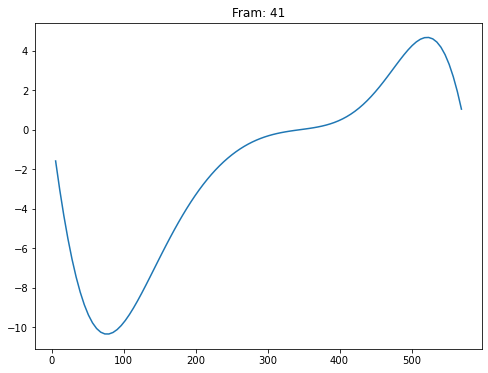

Energy: 0.0439712842393653


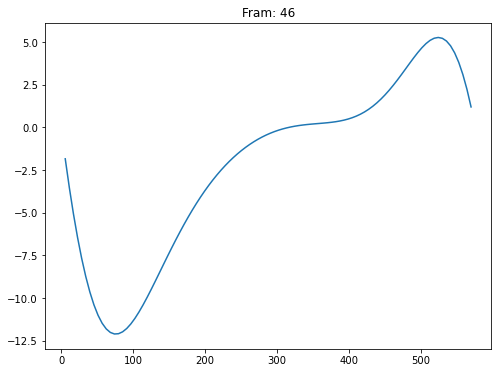

Energy: 0.06778175931649966


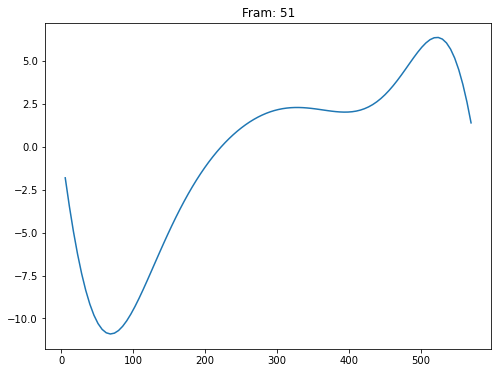

Energy: 0.055439470577930236


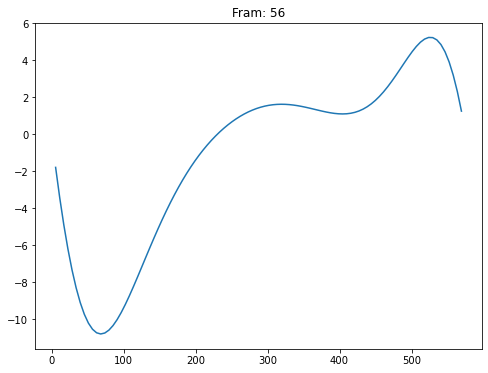

Energy: 0.026765394226540527


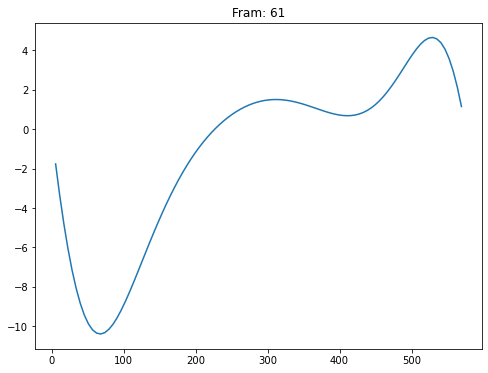

Energy: 0.013557154632490713


In [35]:
videoName = "001BA_Left_20160203_132002.avi"

x_nodes = np.linspace(0,575, N+2)
    
middle = getMiddleWaveform(videoName, 1, False)
coefficients = middle[2]
y_nodes = Polynomial(coefficients, x_nodes)
    
initialLengths = initialLengthsFinder(x_nodes, y_nodes)
K_arr = np.ones(N+1)/initialLengths

guess = np.zeros(N)
    
    
for i in [41,46,51,56,61]:
    u = getFramePotential(videoName, i, initialLengths, K_arr,iGuess=guess)
    print("Energy: "+str(u[0]))
    guess = u[1]

We still have a large fluctuation of energy even though the graphs don't change much.

Next Tasks:
    
-Plot a time evolution movie of the $V(x)$ profile.

-Add noise to displacements and/or polynomial fit to determine if the marginal error from our approximations is indeed marginal or if it may be the cuase of such large fluctuations on the $U(t)$ profile.
    
-Investigate displacement and energy profiles between consecutive frames showing strong fluctuations.

We will first extract the $V(x)$ profile of a frame (and subsequently make the graph three dimensional by adding a time axis created by the movie.) Seeing as we're employing a discretization, we will plot the potential energy of of segment position, where segment position, in this case, will be dictated by the horizontal component of the midpoint of the segment. In principle, this should contain more (and at least as much) information as a plot of the neergy versus segment/node number.

In [23]:
def plotFramePotential(videoName, imageNumber, initialLengths, K_arr, output = False, iGuess = np.zeros(N)):
    
    middle = getMiddleWaveform(videoName, imageNumber, output)
    x_nodes = np.linspace(0,575, N+2)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
#     plt.figure()
#     plt.plot(x_nodes,y_nodes)
#     plt.show()
    
    displacements = minimize(potentialEnergy, iGuess, args = (x_nodes, y_nodes, initialLengths, K_arr))
    
#     print(displacements.x)

    
#     plt.figure(figsize=(8,6))
#     plt.plot(x_nodes[1:-1], displacements.x)
#     plt.title(f"Fram: {imageNumber}")
#     plt.show()

    new_x_nodes = np.linspace(0,575, N+2)
    
    for i in range(1, new_x_nodes.shape[0]-1):
        new_x_nodes[i] = new_x_nodes[i] + displacements.x[i-1]
    
    new_y_nodes = Polynomial(coefficients, new_x_nodes)
    
    segmentMidpoints = np.zeros(N+1)
    
    for i in range(N+1):
        
        segmentMidpoints[i] = 0.5*(new_x_nodes[i]+new_x_nodes[i+1])
    
    
    segmentEnergies = np.zeros(N+1)
    
    for i in range(N+1):
        
        p1 = (new_x_nodes[i], new_y_nodes[i])
        p2 = (new_x_nodes[i+1], new_y_nodes[i+1])
        
        newDist = euclideanDistance(p1, p2)
        
        segmentEnergies[i] = 0.5 * K_arr[i] * (newDist - initialLengths[i])**2
        
    
    
    plt.figure(figsize = (12,8))
    plt.plot(segmentMidpoints, segmentEnergies)
    plt.title("Potential Profile on Frame " + str(imageNumber))
    plt.ylim((0,0.1))
    plt.xlim((0,600))
    plt.savefig("Potential_Profiles/"+videoName+"/V_x/FRAMES/"+str(imageNumber)+".png")
    plt.close()
    
    return displacements.x #for the next guess

In [24]:
def get_V_x_Frames(videoName, totalImages = 139, increment = 1):   #NO RETURN, JUST GET FIGURES
    
    if os.path.exists("Potential_Profiles/"+videoName+"/V_x/FRAMES/"):
        print("Already Processed.")
        return
    
    if not os.path.exists("Potential_Profiles/"+videoName+"/"):
        os.mkdir("Potential_Profiles/"+videoName+"/")
        
    if not os.path.exists("Potential_Profiles/"+videoName+"/V_x/"):
        os.mkdir("Potential_Profiles/"+videoName+"/V_x/")
        
    if not os.path.exists("Potential_Profiles/"+videoName+"/V_x/FRAMES/"):
        os.mkdir("Potential_Profiles/"+videoName+"/V_x/FRAMES/")
    
    imageNumber = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = np.linspace(0,575, N+2)
    
    middle = getMiddleWaveform(videoName, imageNumber, False)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
    initialLengths = initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(N+1)/initialLengths
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(totalImages)
    iGuess = np.zeros(N)
    
    while imageNumber <= totalImages:
        
        print(f'Processing Frame: {imageNumber}')
        newGuess = plotFramePotential(videoName, imageNumber, initialLengths, K_arr, False, iGuess)
        imageNumber += increment
        iGuess = newGuess
    
    

We can check that the functions work before properly adapting our video-generating function.

In [25]:
get_V_x_Frames("001BA_Left_20160203_132002.avi")

Processing Frame: 1
Processing Frame: 2
Processing Frame: 3


KeyboardInterrupt: 

In [26]:
def formattedImageCreator_V_x(videoName):
    
    if os.path.exists("Potential_Profiles/"+videoName+"/V_x/FRAMES_RESIZED/"):
        print("Already Processed.")
        return
    
    os.mkdir("Potential_Profiles/"+videoName+"/V_x/FRAMES_RESIZED/")
    
    path = "Potential_Profiles/"+videoName+"/V_x/FRAMES"
    mean_height = 0
    mean_width = 0
  
    num_of_images = len(os.listdir(path))
    
    for file in os.listdir(path): 
        im = Image.open(os.path.join(path, file)) 
        width, height = im.size 
        mean_width += width 
        mean_height += height
    
    mean_width = int(mean_width / num_of_images) 
    mean_height = int(mean_height / num_of_images)
    
    imageIterator = 1
    
    while imageIterator <= num_of_images:
        imageName = str(imageIterator) + ".png"
        im = Image.open(os.path.join(path, imageName))
        
        width, height = im.size 
        
        # resizing  
        imResize = im.resize((mean_width, mean_height), Image.ANTIALIAS)  
        imResize.save( "Potential_Profiles/"+videoName+"/V_x/FRAMES_RESIZED/"+str(imageIterator)+".png", quality = 95) # setting quality
        imageIterator+=1
    

In [27]:
def generate_video_V_x(videoName):
    
    if os.path.exists("Potential_Profiles/"+videoName+"/V_x/"+"V_x_evolution.mp4"):
        print("Already processed.")
        return
    
    
    image_folder = "Potential_Profiles/"+videoName+"/V_x/"+"FRAMES_RESIZED"
    video_name = "Potential_Profiles/"+videoName+"/V_x/"+"V_x_evolution.mp4"
    
    #must create the image array
    
    num_of_images = len(os.listdir(image_folder))
    
    imageIterator = 1
    images=[]
    
    while imageIterator <= num_of_images:
        imageName = os.path.join(image_folder, str(imageIterator)+".png")
        images.append(imageName)
        imageIterator+=1
    #print(images)
    
        
    frame = cv2.imread(images[0]) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
    
    video = cv2.VideoWriter(video_name,0x7634706d , 5, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(image))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated

We generate the movie. This could hint at any potential localization of potential energy, which in turn could point to underlying issues in our calculations. It will also highlight the "problematic" frames.

In [ ]:
formattedImageCreator_V_x("001BA_Left_20160203_132002.avi")

In [ ]:
generate_video_V_x("001BA_Left_20160203_132002.avi")

Indeed, the evolution is not too smooth, and we have a serious localization of potential energy at the boundaries, which are problematic to start with as a result of the video quality and the amount of processing undergone by the data.

We still do not know if the issue is from our fit or the movie, though our waveform evolution looks fine. To this end, we will choose a frame, check the potential, apply noise, and refetch the potential to see how it has changed. Ideally, we do this for all of the frames, but we will start with one.

In [28]:
def noise(x, maxP=1):
    chg = np.zeros(x.shape[0])
    for i in range(chg.shape[0]):
        chg[i] = 1+random.uniform(-maxP,maxP)/10
    return x*chg      

We postpone the noise test. Instead, we are going to run tests on a cornea that deforms until it is a straight line and observe the energy versus horizontal position profile. We will then try to work with the upper waveform and to try and see if we get a clearer signal.

We do this on a new notebook for clarity.

## Testing functions - Ignorable (Moved to Script Upon Validation)